# 17: Optimizers - SGD with Momentum

### 🎯 Objective
We are moving from *architectural* metaparameters (Batch Norm, Activation) to *optimization* metaparameters. 
This notebook investigates **Momentum** in Stochastic Gradient Descent. We will see how carrying forward a bit of the "velocity" from previous updates helps the model converge faster and smoother.

### 📚 Key Concepts
- **SGD:** Updates weights based on the gradient of the current batch.
- **Momentum ($\beta$):** A parameter (usually 0.9) that adds a fraction of the *previous* update vector to the *current* update.
- **The Experiment:** We will train a simple classifier on the "Qwerties" dataset using momentum values ranging from 0 (standard SGD) to 0.999.

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## 1. Create the Data

We generate the "Qwerties" dataset: 3 classes of data points (clouds) in a 2D space. This is a simple classification problem perfect for testing optimizers.

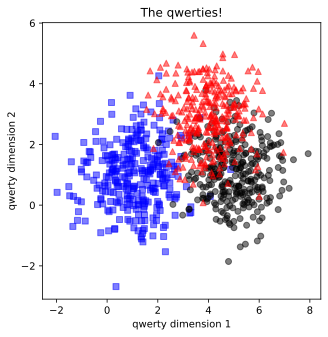

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

## 2. Define the Model

We wrap the model creation in a function so we can pass the **momentum** value to the optimizer dynamically.

**Key Line:**
`optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=momentum)`

In [4]:
# create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (note extra input!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer


In [5]:
# confirm that the optimizer has momentum
# We create a dummy model just to inspect the optimizer object
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## 3. Training Function
Standard training loop.

In [6]:
# a function that trains the model


# number of epochs
numepochs = 50


def function2trainTheModel(momentum):

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


## 4. The Experiment: Varying Momentum

We test 5 values for momentum:
* `0`: Pure SGD (no momentum).
* `0.5`: Mild momentum.
* `0.9`: Standard default value.
* `0.95`: Strong momentum.
* `0.999`: Extreme momentum (might overshoot).

**What to look for:**
Higher momentum usually leads to faster convergence (loss drops quicker), but setting it *too* high might cause the model to overshoot and become unstable.

In [7]:
# momentum values to use
momenta = [0,.5,.9,.95,.999]

# initialize results matrix
results = np.zeros((numepochs,len(momenta),3))

# test all momentum values on the same data (different model instances)
for idx,mom in enumerate(momenta):
  trainAcc,testAcc,losses,net = function2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc

/tmp/ipython-input-3160701296.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,idx,0] = losses
/tmp/ipython-input-3160701296.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,idx,2] = testAcc


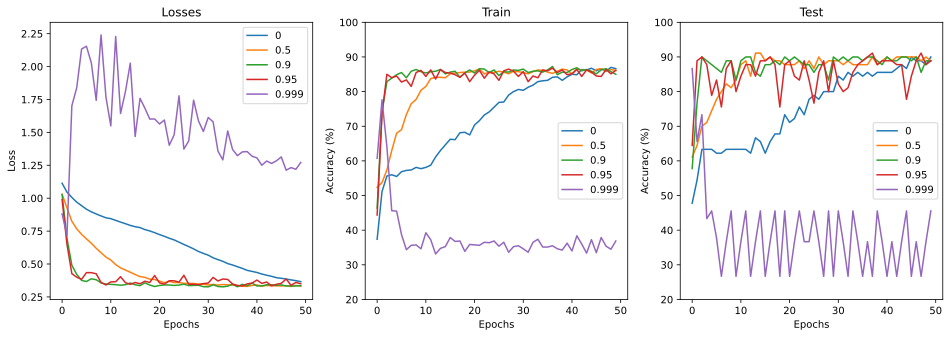

In [8]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()